In [1]:
#pip install matplotlib

In [2]:
#pip install sklearn

In [3]:
#pip install pandas

In [4]:
#pip install nltk

In [5]:
#pip install keras

In [6]:
#pip install tensorflow

In [7]:
#pip install sentence_transformers

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
import tensorflow as tf

import json
from pathlib import Path

/Users/dabereabasse/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/dabereabasse/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dabereabasse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dabereabasse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
path_to_training = Path("training")
path_to_test = Path("test")

## Combinaison Transcription+graphe pour chaque dialogue

In [10]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]*>|(?:um|uh)', '', text)

    # Tokenization des mots
    words = word_tokenize(text)

    # Supprimer les mots vides (stop words)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Stemming (réduction à la racine des mots)
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]

    # Rejoindre les mots traités en une seule chaîne de texte
    processed_text = ' '.join(words)

    return processed_text


def get_xi(transcription_id):
       discourse_graph = [] # list, i attribute j
       with open(path_to_training / f"{transcription_id}.txt", 'r') as f:
              for line in f: discourse_graph.append(line.strip())
       
       with open(path_to_training / f"{transcription_id}.json", 'r') as f:
              transcription = json.load(f)

       x_i = [] # list, speaker: attribute: text
       prefix_i = ["" for i in range(len(transcription))] # list des prelations pour lesquelles i est prefixes
       suffix_j = ["" for i in range(len(transcription))] # list des prelations pour lesquelles j est suffixes

       for line in discourse_graph:
              tmp = line.split()
              i = int(tmp[0])
              j = int(tmp[-1])

              if prefix_i[i]!= "": prefix_i[i]+=','
              prefix_i[i] += ("p"+tmp[1])

              if suffix_j[j]!= "": suffix_j[j]+=','
              suffix_j[j] += ("s"+tmp[1])

       for i in range(len(transcription)):
              replique = transcription[i]
              text = preprocess_text(replique['text'])
              x_i.append(text)

       return x_i, prefix_i, suffix_j


## Concatenater des: x_i -> X, prefix_i -> A, suffix_i -> B

In [11]:
# Recup des ids
transcription_ids = []

transcripts = path_to_training.glob('*.json')
for transcript in transcripts:
    transcription_ids.append(transcript.name[:-5])

In [12]:
# creation de X contenant les repliques x_i
X = [] #list des repliques
A = [] #list des prefixes
B = [] #list des suffixes

for transcription_id in  transcription_ids:
    x_i, prefix_i, suffix_j = get_xi(transcription_id)
    X.extend(x_i)
    A.extend(prefix_i)
    B.extend(suffix_j)

In [13]:
print("len(X):", len(X))
print("len(A):", len(A))
print("len(B):", len(B))

len(X): 72623
len(A): 72623
len(B): 72623


## Concatenation X+A+B -> Z, recuperation de y

In [14]:
Z = np.concatenate([np.array(X).reshape(-1,1), np.array(A).reshape(-1,1), np.array(B).reshape(-1,1)], axis=1)
Z.shape

(72623, 3)

In [15]:
# creation de y contenant les labels pour chaque x_i
y = [] # concatenation des labels
with open("training_labels.json", 'r') as f:
    labels = json.load(f)

for transcription_id in transcription_ids:
    y.extend(labels[transcription_id])

y = np.array(y).reshape(-1,1)

print(y.shape)

(72623, 1)


## Séperation en Train et Valid

In [16]:
Z_train, Z_valid, y_train, y_valid = train_test_split(Z, y, test_size=0.3, random_state=42)

## Recup de A_train, B_train et transformation en variables dummies

In [17]:
X_train = Z_train[:,0]
A_train = Z_train[:,1]
B_train = Z_train[:,2]

In [18]:
A_train = pd.DataFrame(A_train, columns=['variable'])
A_train = A_train['variable'].str.get_dummies(sep=',')

B_train = pd.DataFrame(B_train, columns=['variable'])
B_train = B_train['variable'].str.get_dummies(sep=',')

In [19]:
A_train_cols = A_train.columns
B_train_cols = B_train.columns

A_train = A_train.values
B_train = B_train.values

In [20]:
A_train[:5]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [21]:
A_train_cols

Index(['pAcknowledgement', 'pAlternation', 'pBackground',
       'pClarification_question', 'pComment', 'pConditional', 'pContinuation',
       'pContrast', 'pCorrection', 'pElaboration', 'pExplanation',
       'pNarration', 'pParallel', 'pQ-Elab', 'pQuestion-answer_pair',
       'pResult'],
      dtype='object')

## Vectorisation de X_train et Reconstruction de Z_train = X_train + A_train + B_train

In [23]:
bert = SentenceTransformer('distilbert-base-uncased')
X_train_bert = bert.encode(X_train, show_progress_bar=True)

No sentence-transformers model found with name /Users/dabereabasse/.cache/torch/sentence_transformers/distilbert-base-uncased. Creating a new one with MEAN pooling.
Batches: 100%|██████████| 1589/1589 [01:41<00:00, 15.64it/s]


In [24]:
Z_train = np.concatenate([X_train_bert, A_train, B_train], axis=1)

## Recup de A_valid, B_valid et transformation en variables dummies avec les memes colonnes que A_train, B_train

In [25]:
X_valid = Z_valid[:,0]
A_valid = Z_valid[:,1]
B_valid = Z_valid[:,2]

In [26]:
# variables dummies
A_valid = pd.DataFrame(A_valid, columns=['variable'])
A_valid = A_valid['variable'].str.get_dummies(sep=',')

B_valid = pd.DataFrame(B_valid, columns=['variable'])
B_valid = B_valid['variable'].str.get_dummies(sep=',')

In [ ]:
A_valid.head()

,pAcknowledgement,pAlternation,pBackground,pClarification_question,pComment,pConditional,pContinuation,pContrast,pCorrection,pElaboration,pExplanation,pNarration,pParallel,pQ-Elab,pQuestion-answer_pair,pResult
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# rearangement des colonnes de A_valid et B_valid pour que ça soit pareil avec celles des train

A_valid = A_valid.reindex(columns=A_train_cols).fillna(0)
B_valid = B_valid.reindex(columns=B_train_cols).fillna(0)

A_valid = A_valid.values
B_valid = B_valid.values

## Vectorisation de X_valid et Reconstruction de Z_valid = X_valid + A_valid + B_valid

In [ ]:
X_valid_bert = bert.encode(X_valid, show_progress_bar=True)

Batches: 100%|██████████| 681/681 [00:45<00:00, 15.04it/s]


In [ ]:
Z_valid = np.concatenate([X_valid_bert, A_valid, B_valid], axis=1)

# Modele avec DNN

In [ ]:
print('Z_train.shape:', Z_train.shape)
print('Z_valid.shape:', Z_valid.shape)

Z_train.shape: (50836, 800)
Z_valid.shape: (21787, 800)


In [ ]:
model = tf.keras.Sequential([
    Dense(400, input_dim=800, activation='relu'),
    Dropout(0.5),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = model.fit(Z_train, y_train, epochs=10, batch_size=32, validation_data=(Z_valid, y_valid))

Epoch 1/10
1589/1589 [==============================] - 3s 2ms/step - loss: 0.3627 - accuracy: 0.8228 - val_loss: 0.3550 - val_accuracy: 0.8359
Epoch 2/10
1589/1589 [==============================] - 2s 1ms/step - loss: 0.3464 - accuracy: 0.8306 - val_loss: 0.3296 - val_accuracy: 0.8346
Epoch 3/10
1589/1589 [==============================] - 2s 1ms/step - loss: 0.3411 - accuracy: 0.8299 - val_loss: 0.3382 - val_accuracy: 0.8251
Epoch 4/10
1589/1589 [==============================] - 2s 2ms/step - loss: 0.3404 - accuracy: 0.8311 - val_loss: 0.3320 - val_accuracy: 0.8222
Epoch 5/10
1589/1589 [==============================] - 2s 1ms/step - loss: 0.3376 - accuracy: 0.8319 - val_loss: 0.3349 - val_accuracy: 0.8269
Epoch 6/10
1589/1589 [==============================] - 2s 1ms/step - loss: 0.3364 - accuracy: 0.8315 - val_loss: 0.3277 - val_accuracy: 0.8340
Epoch 7/10
1589/1589 [==============================] - 2s 1ms/step - loss: 0.3360 - accuracy: 0.8332 - val_loss: 0.3374 - val_accuracy:

In [ ]:
y_pred = model.predict(Z_valid)
y_pred = np.where(y_pred>=0.5, 1, 0)

print(f1_score(y_valid, y_pred))

681/681 [==============================] - 0s 479us/step
0.2641660015961692


## Modele avec DNN avec class_weight

In [ ]:
model = tf.keras.Sequential([
    Dense(400, input_dim=800, activation='relu'),
    Dropout(0.5),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

count_class_0 = len(y_train) - np.sum(y_train)
count_class_1 = np.sum(y_train)
total = len(y_train)
frequency_class_0 = count_class_0 / total
frequency_class_1 = count_class_1 / total
inverse_weight_class_0 = 1 / frequency_class_0
inverse_weight_class_1 = 1 / frequency_class_1
class_weights = {0: inverse_weight_class_0, 1: inverse_weight_class_1}

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = model.fit(Z_train, y_train, epochs=10, batch_size=32, validation_data=(Z_valid, y_valid), class_weight= class_weights)

Epoch 1/10
1589/1589 [==============================] - 3s 2ms/step - loss: 0.9890 - accuracy: 0.7066 - val_loss: 0.4658 - val_accuracy: 0.6769
Epoch 2/10
1589/1589 [==============================] - 2s 2ms/step - loss: 0.9382 - accuracy: 0.7218 - val_loss: 0.4880 - val_accuracy: 0.6854
Epoch 3/10
1589/1589 [==============================] - 2s 1ms/step - loss: 0.9327 - accuracy: 0.7250 - val_loss: 0.4802 - val_accuracy: 0.7138
Epoch 4/10
1589/1589 [==============================] - 2s 1ms/step - loss: 0.9227 - accuracy: 0.7255 - val_loss: 0.4419 - val_accuracy: 0.7308
Epoch 5/10
1589/1589 [==============================] - 2s 1ms/step - loss: 0.9163 - accuracy: 0.7332 - val_loss: 0.4105 - val_accuracy: 0.7605
Epoch 6/10
1589/1589 [==============================] - 2s 2ms/step - loss: 0.9124 - accuracy: 0.7272 - val_loss: 0.4547 - val_accuracy: 0.7331
Epoch 7/10
1589/1589 [==============================] - 2s 1ms/step - loss: 0.9034 - accuracy: 0.7372 - val_loss: 0.4583 - val_accuracy:

In [ ]:
y_pred = model.predict(Z_valid)
y_pred = np.where(y_pred>=0.5, 1, 0)

print(f1_score(y_valid, y_pred))

681/681 [==============================] - 0s 481us/step
0.5558220502901354


## Modele avec un CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [ ]:
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(800, 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.2),  # Pour éviter le surapprentissage (overfitting)
    Dense(1, activation='sigmoid')  # Couche de sortie binaire
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = model.fit(Z_train, y_train, epochs=6, batch_size=32, validation_data=(Z_valid, y_valid), class_weight= class_weights)

Epoch 1/6
1589/1589 [==============================] - 9s 6ms/step - loss: 0.9951 - accuracy: 0.7150 - val_loss: 0.5162 - val_accuracy: 0.7133
Epoch 2/6
1589/1589 [==============================] - 9s 5ms/step - loss: 0.9919 - accuracy: 0.7150 - val_loss: 0.4951 - val_accuracy: 0.7144
Epoch 3/6
1589/1589 [==============================] - 9s 5ms/step - loss: 0.9898 - accuracy: 0.7135 - val_loss: 0.4618 - val_accuracy: 0.7429
Epoch 4/6
1589/1589 [==============================] - 9s 5ms/step - loss: 0.9870 - accuracy: 0.7144 - val_loss: 0.5225 - val_accuracy: 0.7118
Epoch 5/6
1589/1589 [==============================] - 9s 5ms/step - loss: 0.9822 - accuracy: 0.7138 - val_loss: 0.5014 - val_accuracy: 0.7260
Epoch 6/6
1589/1589 [==============================] - 9s 5ms/step - loss: 0.9844 - accuracy: 0.7165 - val_loss: 0.4711 - val_accuracy: 0.7269


In [ ]:
y_pred = model.predict(Z_valid)
y_pred = np.where(y_pred>=0.5, 1, 0)

print(f1_score(y_valid, y_pred))

681/681 [==============================] - 1s 1ms/step
0.5323379174852653


In [ ]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

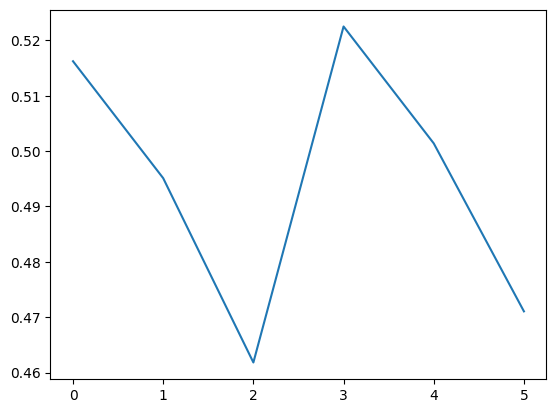

In [ ]:
plt.plot(range(len(model_history.history['val_loss'])), model_history.history['val_loss'])

## XGBoost

In [ ]:
pip install xgboost

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.9 MB 5.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(Z_train, label=y_train)
dtest = xgb.DMatrix(Z_valid, label=y_valid)

In [ ]:
# Paramètres du modèle XGBoost
param = {
    'max_depth': 6,  # Profondeur maximale de l'arbre
    'eta': 0.3,  # Taux d'apprentissage
    'objective': 'binary:logistic',  # Objectif : classification binaire
    'eval_metric': 'logloss'  # Métrique d'évaluation : log loss
}

In [ ]:
# Entraînement du modèle
num_round = 100  # Nombre d'itérations (boosting rounds)
bst = xgb.train(param, dtrain, num_round)

In [ ]:
# Prédiction sur l'ensemble de test
predictions = bst.predict(dtest)


In [ ]:
predictions = np.where(predictions>=0.5, 1, 0)

print(f1_score(y_valid, predictions))

0.4566289527125036
